# DSC212 — Modularity on the Karate Club Graph

This notebook implements **recursive spectral modularity partitioning** on Zachary's Karate Club graph, visualizes partitions after each split, computes node metrics at every iteration, and plots metric evolution. The notebook is arranged to run top-to-bottom without manual edits.

In [11]:
# Cell 1: Imports & config
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from collections import defaultdict, OrderedDict

# Notebook-wide configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
plt.rcParams['figure.figsize'] = (8,6)

# Create an output folder for figures
OUTDIR = "figures"
os.makedirs(OUTDIR, exist_ok=True)
print("Setup done. OUTDIR =", OUTDIR)

Setup done. OUTDIR = figures


In [12]:
# Cell 2: Load Karate graph and build adjacency, degree, m, node ordering
G = nx.karate_club_graph()  # Zachary's Karate Club (34 nodes)
nodes = sorted(G.nodes())   # deterministic ordering
node_to_index = {n:i for i,n in enumerate(nodes)}

# adjacency and degrees (in this node order)
A = nx.to_numpy_array(G, nodelist=nodes)
k = A.sum(axis=1)  # degree vector (original graph degrees)
m = A.sum() / 2.0  # number of edges (scalar)

print(f"Nodes: {len(nodes)}, Edges m = {m}")

Nodes: 34, Edges m = 231.0


In [13]:
# Cell 3: modularity helpers
EPS = 1e-10

def modularity_matrix_full(A, k, m):
    """Return full modularity matrix B = A - k k^T / (2m)."""
    return A - np.outer(k, k) / (2.0 * m)

B_full = modularity_matrix_full(A, k, m)
print("B_full computed (shape):", B_full.shape)

B_full computed (shape): (34, 34)


In [14]:
# Cell 4: try_split implementation
def try_split(node_list, A_global=A, k_global=k, m_global=m, node_to_index=node_to_index):
    """
    Try to split the set node_list by leading eigenvector of restricted modularity matrix.
    Returns (plus_list, minus_list, delta_Q, leading_eigval) if accepted, else None.
    """
    if len(node_list) <= 1:
        return None

    idx = [node_to_index[n] for n in node_list]
    A_sub = A_global[np.ix_(idx, idx)]
    k_sub = k_global[idx]
    B_sub = A_sub - np.outer(k_sub, k_sub) / (2.0 * m_global)  # restricted modularity

    # compute symmetric eigendecomposition
    w, v = np.linalg.eigh(B_sub)
    leading_val = w[-1]
    leading_vec = v[:, -1]

    # eigenvalue stopping rule
    if leading_val <= EPS:
        return None

    # split by sign of leading eigenvector
    s = np.where(leading_vec >= 0.0, 1, -1)
    delta_Q = (s @ B_sub @ s) / (4.0 * m_global)

    if delta_Q <= EPS:
        return None

    plus = [node_list[i] for i in range(len(node_list)) if s[i] == 1]
    minus = [node_list[i] for i in range(len(node_list)) if s[i] == -1]

    if len(plus) == 0 or len(minus) == 0:
        return None

    return plus, minus, float(delta_Q), float(leading_val)

# quick smoke test
print('Try splitting full set...')
res = try_split(nodes)
print('Result:', 'Split accepted' if res is not None else 'No split (leading eigenvalue <= 0 or no gain)')

Try splitting full set...
Result: Split accepted


In [15]:
# Cell 5: partition_pass implementation
def partition_pass(parts, A_global=A, k_global=k, m_global=m, node_to_index=node_to_index):
    """
    Given a list of communities (parts: list of lists of node ids),
    attempt to split each community once. Return (new_parts, did_split, total_delta_Q, split_info)
    where split_info is a list of (original_part, plus, minus, delta_Q, leading_val) for each accepted split.
    """
    new_parts = []
    did_split = False
    total_delta_Q = 0.0
    split_info = []
    for part in parts:
        res = try_split(part, A_global, k_global, m_global, node_to_index)
        if res is None:
            new_parts.append(part)
        else:
            plus, minus, delta_Q, leading_val = res
            new_parts.append(plus)
            new_parts.append(minus)
            did_split = True
            total_delta_Q += delta_Q
            split_info.append((part, plus, minus, delta_Q, leading_val))
    return new_parts, did_split, total_delta_Q, split_info

# quick smoke test on initial partition
parts0 = [list(nodes)]
parts1, did_split, total_delta_Q, split_info = partition_pass(parts0)
print('Did split?', did_split, 'Total delta Q:', total_delta_Q)
if did_split:
    print('Split info example:', split_info[0])

Did split? True Total delta Q: 0.4036281179138322
Split info example: ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 0.4036281179138322, 17.108707741041368)


In [16]:
# Cell 6: modularity and recursive history runner
def compute_modularity(partition, A_global=A, k_global=k, m_global=m, nodes=nodes):
    """Compute modularity Q for a given partition (list of communities with node ids matching 'nodes')."""
    label = {n: cid for cid, com in enumerate(partition) for n in com}
    two_m = 2.0 * m_global
    Q = 0.0
    N = len(nodes)
    for i in range(N):
        for j in range(N):
            if label[nodes[i]] == label[nodes[j]]:
                Q += A_global[i, j] - (k_global[i] * k_global[j]) / two_m
    return Q / two_m

def run_recursive_bisection_record_history(A_global=A, k_global=k, m_global=m, nodes=nodes, node_to_index=node_to_index):
    parts = [list(nodes)]
    partitions_history = [parts.copy()]
    split_history = [None]
    Q_history = [compute_modularity(parts, A_global, k_global, m_global, nodes)]

    iter_count = 0
    while True:
        iter_count += 1
        parts_new, did_split, total_delta_Q, split_info = partition_pass(parts, A_global, k_global, m_global, node_to_index)
        if not did_split:
            partitions_history.append(parts_new.copy())
            split_history.append([])
            Q_history.append(compute_modularity(parts_new, A_global, k_global, m_global, nodes))
            break
        else:
            partitions_history.append(parts_new.copy())
            split_history.append(split_info)
            Q_history.append(compute_modularity(parts_new, A_global, k_global, m_global, nodes))
            parts = parts_new
    return partitions_history, Q_history, split_history

# Run the algorithm
partitions_history, Q_history, split_history = run_recursive_bisection_record_history()
for it, parts in enumerate(partitions_history):
    print(f"Iteration {it}: {len(parts)} communities; modularity Q = {Q_history[it]:.6f}")
    for cid, com in enumerate(parts):
        print(f"  C{cid} (size {len(com)}): {sorted(com)}")
    print('-'*60)

Iteration 0: 1 communities; modularity Q = -0.000000
  C0 (size 34): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
------------------------------------------------------------
Iteration 1: 2 communities; modularity Q = 0.403628
  C0 (size 16): [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
  C1 (size 18): [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
------------------------------------------------------------
Iteration 2: 4 communities; modularity Q = 0.430876
  C0 (size 11): [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  C1 (size 5): [4, 5, 6, 10, 16]
  C2 (size 15): [14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33]
  C3 (size 3): [8, 9, 30]
------------------------------------------------------------
Iteration 3: 5 communities; modularity Q = 0.431664
  C0 (size 11): [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  C1 (size 5): [4, 5, 6, 10, 16]
  C2 (size 15): [14, 15,

/tmp/ipython-input-987212838.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')  # many distinct colors


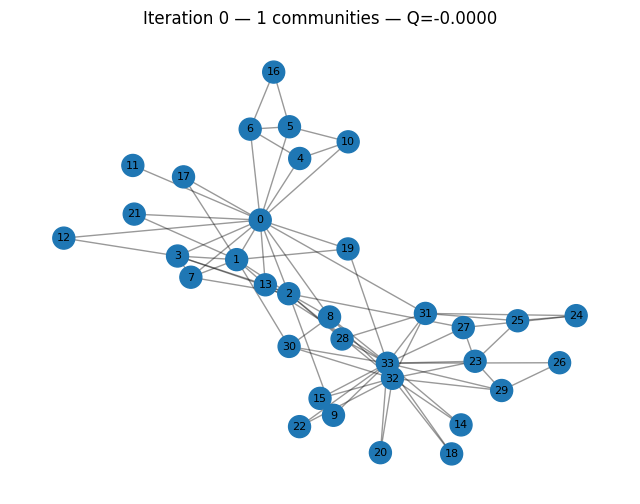

Saved figures/partition_iter00.png


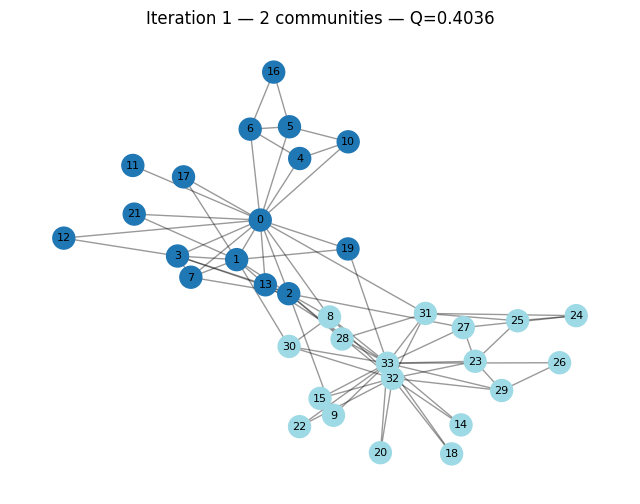

Saved figures/partition_iter01.png


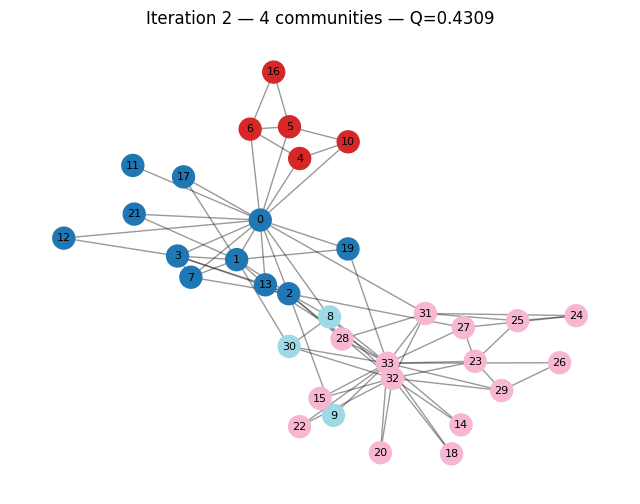

Saved figures/partition_iter02.png


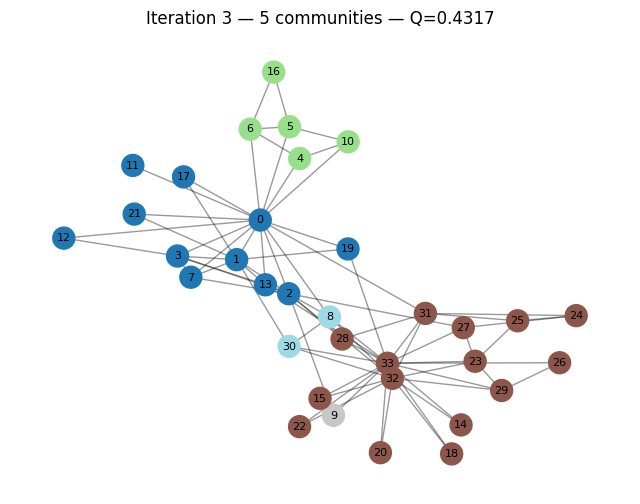

Saved figures/partition_iter03.png


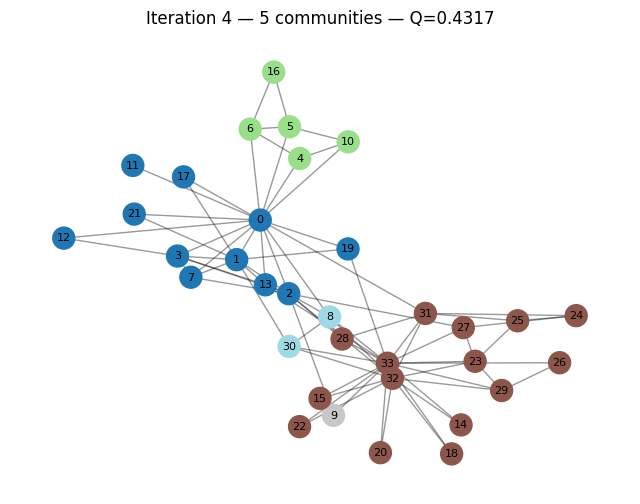

Saved figures/partition_iter04.png


In [17]:
# Cell 7: layout and drawing utilities (fixed layout)
pos = nx.spring_layout(G, seed=RANDOM_SEED)  # fixed layout across iterations
import matplotlib.cm as cm
cmap = plt.cm.get_cmap('tab20')  # many distinct colors

def draw_partition(parts, title=None, savepath=None, nodes_order=nodes, pos=pos):
    community_of = {}
    for cid, com in enumerate(parts):
        for n in com:
            community_of[n] = cid
    node_colors = [community_of[n] for n in nodes_order]
    plt.figure(figsize=(8,6))
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_order, node_color=node_colors,
                           cmap=cmap, node_size=250)
    nx.draw_networkx_labels(G, pos, font_size=8)
    if title is None:
        title = f"{len(parts)} communities"
    plt.title(title)
    plt.axis('off')
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()

# Save visuals for each partition in history
for it, parts in enumerate(partitions_history):
    title = f"Iteration {it} — {len(parts)} communities — Q={Q_history[it]:.4f}"
    savepath = os.path.join(OUTDIR, f"partition_iter{it:02d}.png")
    draw_partition(parts, title=title, savepath=savepath)
    print(f"Saved {savepath}")

In [18]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from collections import defaultdict, OrderedDict


def compute_all_metrics(G):
    return {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'clustering': nx.clustering(G)
    }

metrics_history = { 'degree': [], 'betweenness': [], 'closeness': [], 'clustering': [] }

for it, parts in enumerate(partitions_history):
    metrics = compute_all_metrics(G)
    for key in metrics_history:
        # FIX: Access the metric-specific dictionary before accessing the node's value
        metrics_history[key].append([metrics[key][n] for n in nodes])

metric_dfs = {}
for key, lists in metrics_history.items():
    df = pd.DataFrame(lists, index=list(range(len(lists))), columns=nodes)
    metric_dfs[key] = df
    print(f"Metric {key}: dataframe shape {df.shape}")

Metric degree: dataframe shape (5, 34)
Metric betweenness: dataframe shape (5, 34)
Metric closeness: dataframe shape (5, 34)
Metric clustering: dataframe shape (5, 34)


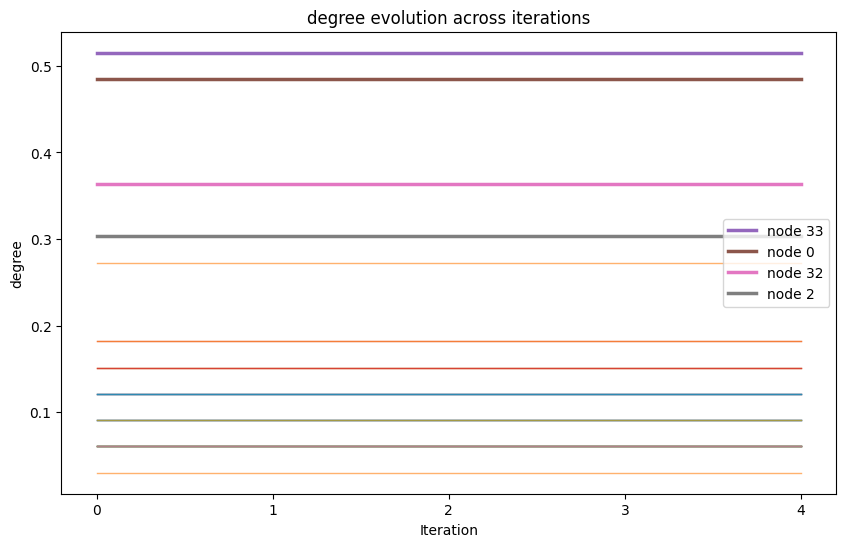

Saved figures/metric_degree_evolution.png


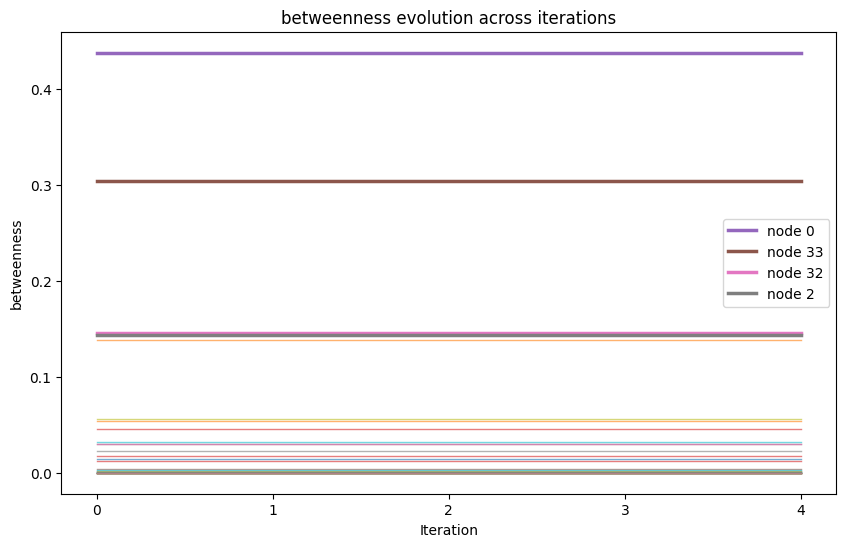

Saved figures/metric_betweenness_evolution.png


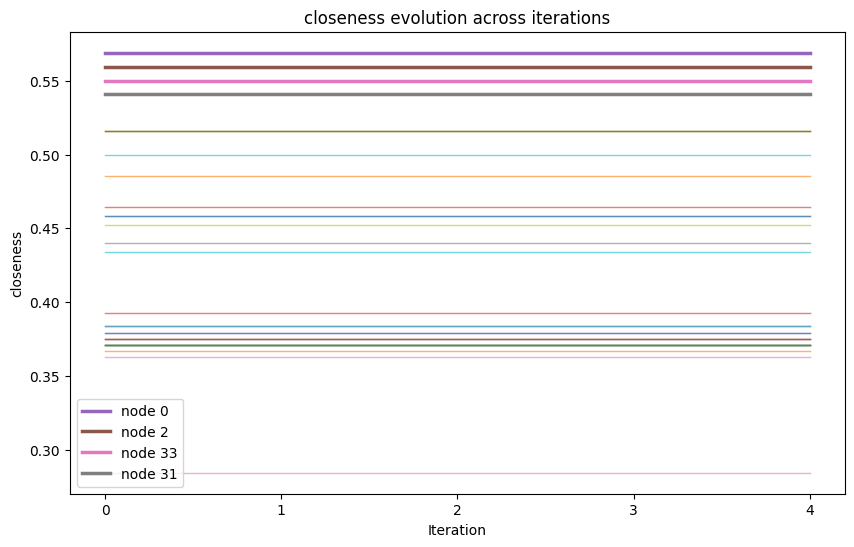

Saved figures/metric_closeness_evolution.png


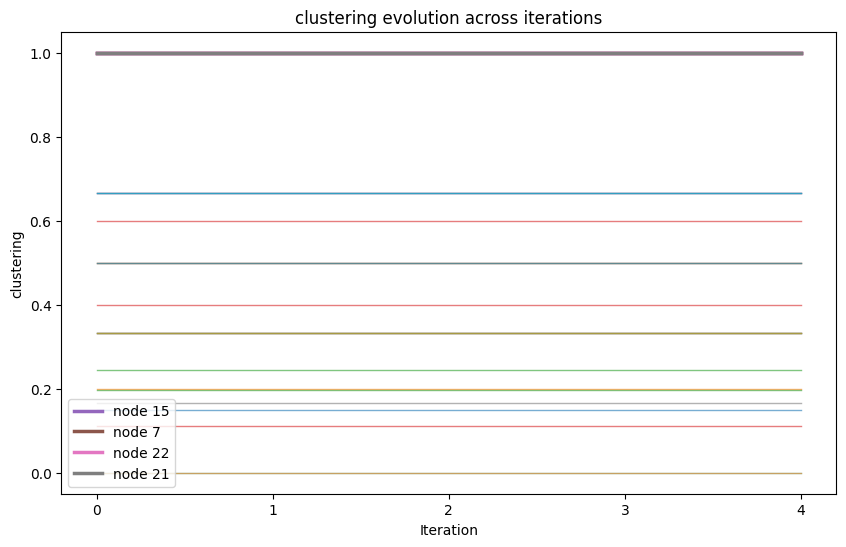

Saved figures/metric_clustering_evolution.png


In [19]:
# Cell 9: plotting metric evolution
def plot_metric_evolution(df, metric_name, outpath=None, highlight_nodes=None):
    plt.figure(figsize=(10,6))
    for node in df.columns:
        plt.plot(df.index, df[node], linewidth=1, alpha=0.6)
    if highlight_nodes is None:
        deg0 = df.loc[0]
        highlight_nodes = deg0.sort_values(ascending=False).index[:4].tolist()
    for n in highlight_nodes:
        plt.plot(df.index, df[n], linewidth=2.5, label=f"node {n}")
    plt.xlabel("Iteration")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} evolution across iterations")
    plt.xticks(df.index)
    if highlight_nodes:
        plt.legend()
    if outpath:
        plt.savefig(outpath, dpi=150, bbox_inches='tight')
    plt.show()

for key, df in metric_dfs.items():
    outpath = os.path.join(OUTDIR, f"metric_{key}_evolution.png")
    plot_metric_evolution(df, key, outpath)
    print(f"Saved {outpath}")

In [20]:
# Cell 10: Automated summary & discussion template
from collections import defaultdict
def top_nodes_over_iterations(df, topk=5):
    top_counts = defaultdict(int)
    for it in df.index:
        topk_nodes = df.loc[it].sort_values(ascending=False).index[:topk]
        for n in topk_nodes:
            top_counts[n] += 1
    return sorted(top_counts.items(), key=lambda x: (-x[1], x[0]))

discussion_lines = []
discussion_lines.append("Automated observations (edit/refine as needed):\n")

for metric, df in metric_dfs.items():
    top_freq = top_nodes_over_iterations(df, topk=5)
    top_summary = ", ".join([f"node {n} ({count}/{len(df.index)})" for n, count in top_freq[:5]])
    discussion_lines.append(f"- {metric.capitalize()} — nodes frequently top-5 across iterations: {top_summary}")

discussion_lines.append("\nInterpretation hints:")
discussion_lines.append("- Nodes that consistently rank high in betweenness are likely bridges between communities and may shift their community membership during recursion.")
discussion_lines.append("- Degree centrality is stable (based on fixed graph), but relative importance inside communities may change; observe per-community statistics for finer insights.")
discussion_lines.append("- Clustering coefficient often increases for nodes inside tightly-knit subgroups as recursion isolates denser cores.")
discussion_lines.append("- Closeness can change if the partitioning isolates subsets but note closeness is a global shortest-path measure on the unchanged graph.")

print('\n'.join(discussion_lines))

Automated observations (edit/refine as needed):

- Degree — nodes frequently top-5 across iterations: node 0 (5/5), node 1 (5/5), node 2 (5/5), node 32 (5/5), node 33 (5/5)
- Betweenness — nodes frequently top-5 across iterations: node 0 (5/5), node 2 (5/5), node 31 (5/5), node 32 (5/5), node 33 (5/5)
- Closeness — nodes frequently top-5 across iterations: node 0 (5/5), node 2 (5/5), node 13 (5/5), node 31 (5/5), node 33 (5/5)
- Clustering — nodes frequently top-5 across iterations: node 7 (5/5), node 15 (5/5), node 16 (5/5), node 21 (5/5), node 22 (5/5)

Interpretation hints:
- Nodes that consistently rank high in betweenness are likely bridges between communities and may shift their community membership during recursion.
- Degree centrality is stable (based on fixed graph), but relative importance inside communities may change; observe per-community statistics for finer insights.
- Clustering coefficient often increases for nodes inside tightly-knit subgroups as recursion isolates de

In [21]:
# Cell 11: Save key outputs: partitions, Q_history, metric_dfs to CSV/JSON for repo inclusion
import json
out = {
    "partitions_history": partitions_history,
    "Q_history": Q_history
}
with open(os.path.join(OUTDIR, "partitions_and_Q.json"), "w") as f:
    json.dump(out, f, indent=2)

for key, df in metric_dfs.items():
    df.to_csv(os.path.join(OUTDIR, f"metric_{key}_history.csv"))
print(f"Saved partition info and metric CSVs to {OUTDIR}")

Saved partition info and metric CSVs to figures
